In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [13]:
df = pd.read_csv(r'/mnt/c/Users/gotha/Downloads/archive (6)/stocks/WYNN.csv', encoding = 'unicode_escape')
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

df['SMA_20'] = df['Adj Close'].rolling(window = 20).mean()
df['EMA_20'] = df['Adj Close'].ewm(span = 20, adjust = False).mean()

ema_12 = df['Adj Close'].ewm(span = 12, adjust = False).mean()
ema_26 = df['Adj Close'].ewm(span = 26, adjust = False).mean()
df['MACD'] = ema_26 - ema_12
df['MACD_Signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()

df['Volatility_10'] = df['Adj Close'].rolling(window = 10).std()

In [14]:
df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop('index', axis = 1, inplace = True)
df_reg = df.copy()

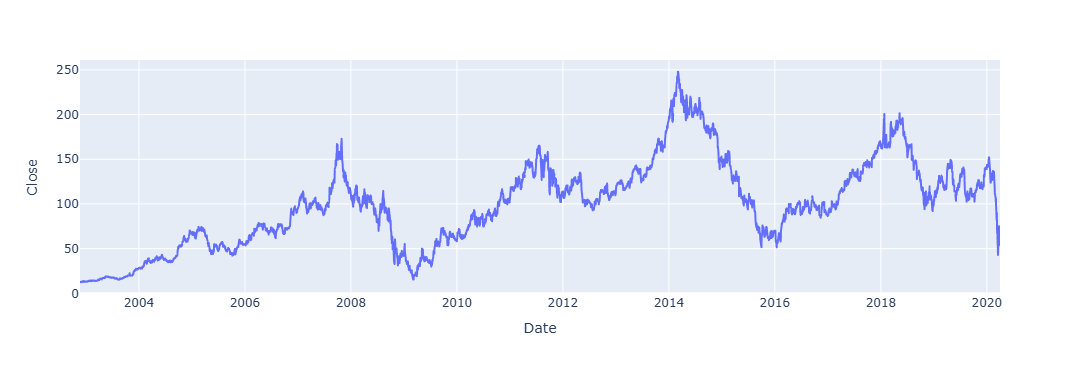

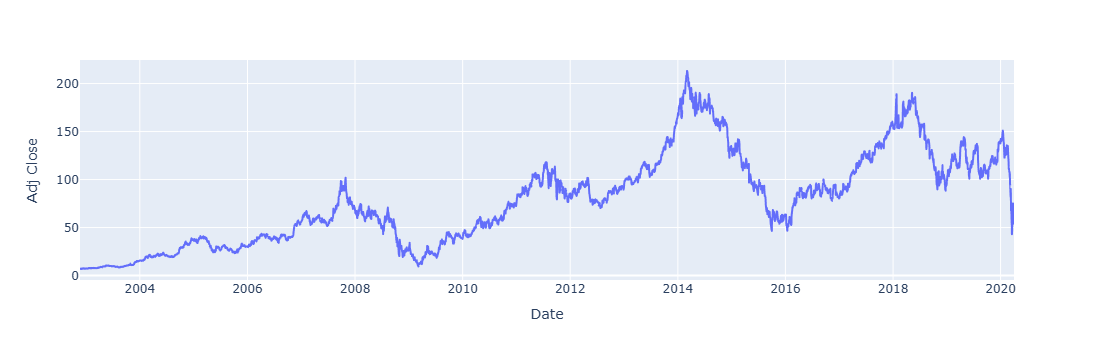

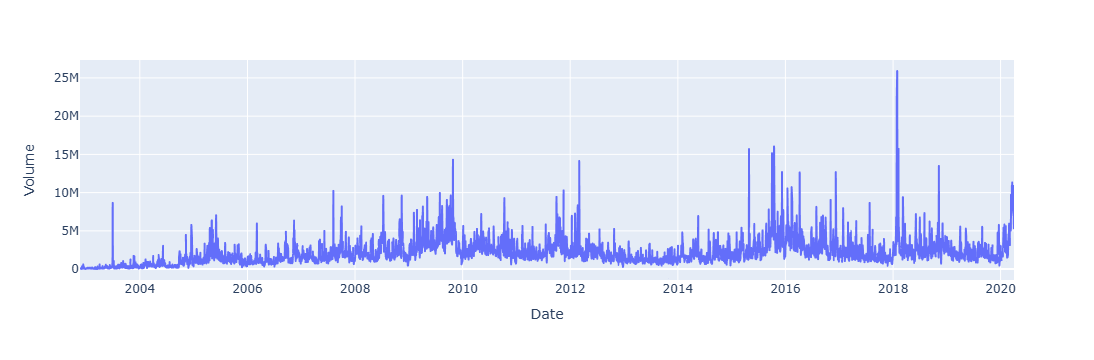

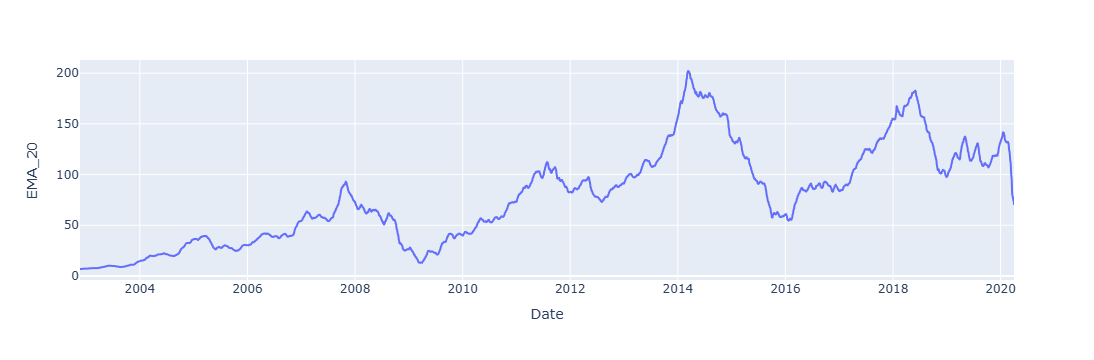

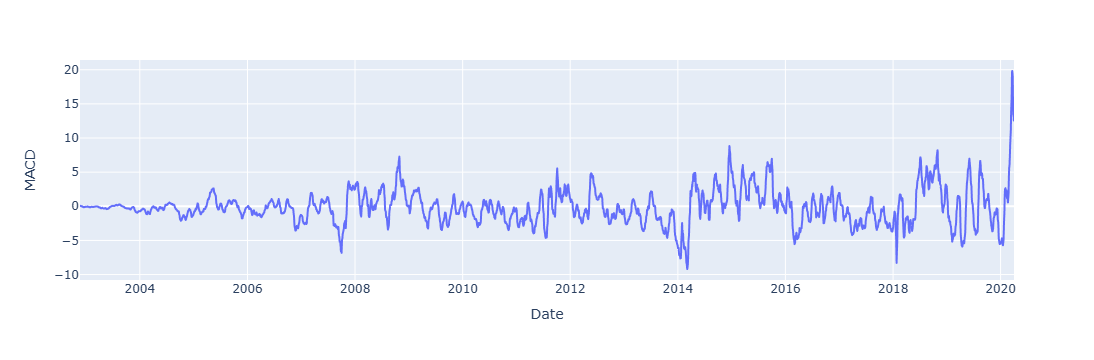

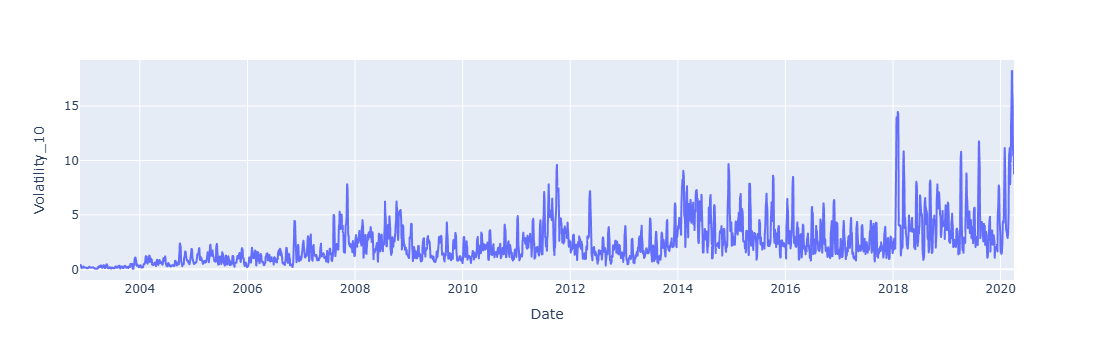

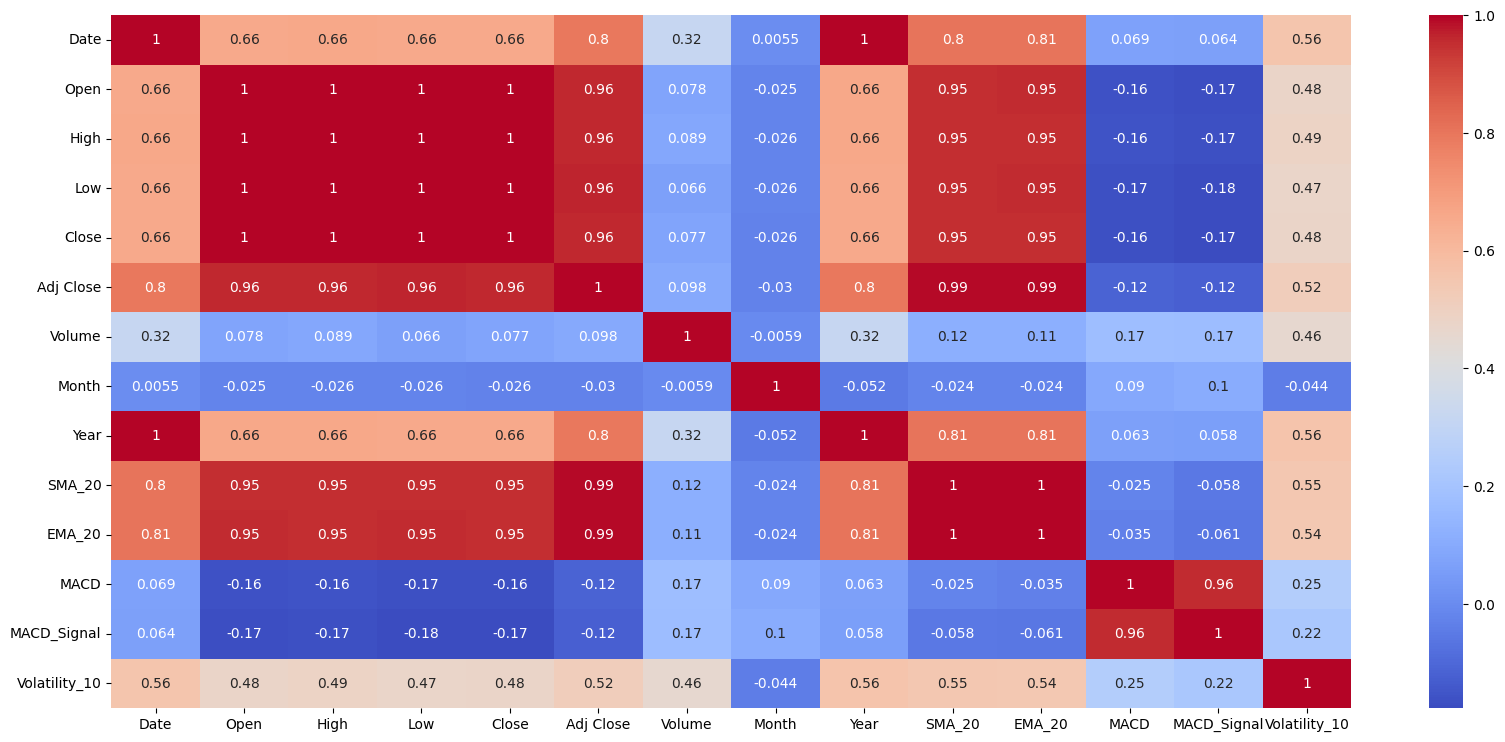

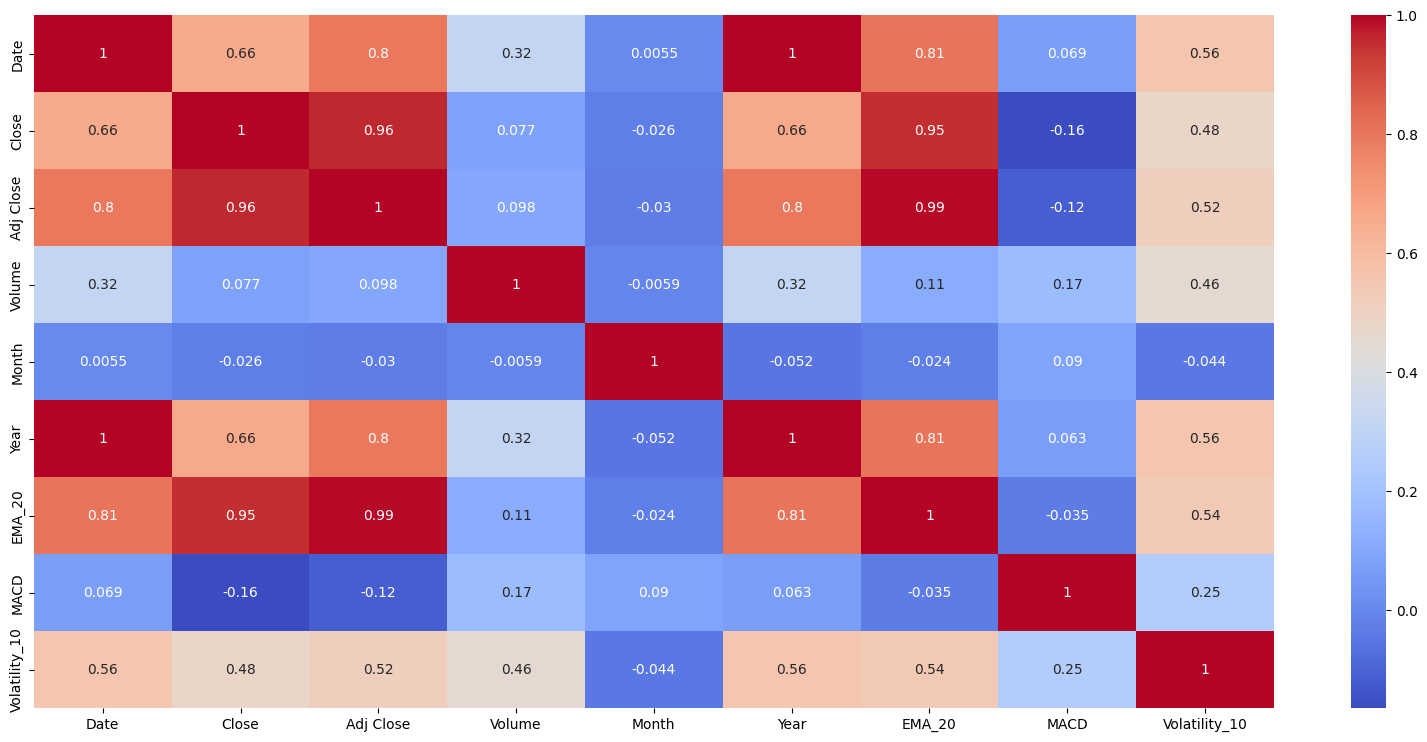

In [15]:
plt.figure(figsize = (20, 9))
sns.heatmap(df.corr(), cmap = 'coolwarm', annot = True)

df_reg.drop(['Open', 'High', 'Low', 'SMA_20', 'MACD_Signal'], axis = 1, inplace = True)
df_reg

plt.figure(figsize = (20, 9))
sns.heatmap(df_reg.corr(), cmap = 'coolwarm', annot = True)

import plotly.express as px
import plotly.graph_objects as go
cols = df_reg.columns
for i in range(len(cols)):
    if cols[i] in ['Date', 'Month', 'Year']:
        continue
    fig = px.line(df_reg, x = 'Date', y = cols[i])
    fig.show()

In [16]:
df_reg = df_reg.drop(['Date', 'Month', 'Year'], axis = 1)
df_reg

,Close,Adj Close,Volume,EMA_20,MACD,Volatility_10
0,12.850000,7.091079,91300,6.869165,0.093175,0.381604
1,12.650000,6.980711,55300,6.879788,0.072991,0.364694
2,12.930000,7.135226,111000,6.904116,0.044019,0.378693
3,12.740000,7.030375,59300,6.916141,0.029183,0.390969
4,12.500000,6.897937,94300,6.914407,0.027792,0.327691
...,...,...,...,...,...,...
4364,71.510002,71.510002,10883600,76.415450,14.197422,11.317923
4365,63.310001,63.310001,9510200,75.167312,13.531361,10.474702
4366,61.099998,61.099998,7156100,73.827568,13.031611,10.418349
4367,60.189999,60.189999,5341600,72.528752,12.564153,10.286681


In [17]:
train_frac = 0.70
val_frac = 0.15
n = len(df)
n_train = int(n*train_frac)
n_val = int(n*(val_frac + train_frac))

train_df = df_reg.iloc[:n_train]
val_df = df_reg[n_train:n_val]
test_df = df_reg[n_val:]

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

train_scaled_df = pd.DataFrame(train_scaled, 
                               index=train_df.index, 
                               columns=train_df.columns)
val_scaled_df   = pd.DataFrame(val_scaled, 
                               index=val_df.index, 
                               columns=val_df.columns)
test_scaled_df  = pd.DataFrame(test_scaled, 
                               index=test_df.index, 
                               columns=test_df.columns)

def create_sequences(data, window, target):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window, :])
        y.append(data[i + window, target])

    return np.array(X), np.array(y)

window = 60
target = 0
X_train, y_train = create_sequences(train_scaled, window, target)
X_test, y_test = create_sequences(test_scaled, window, target)
X_val, y_val = create_sequences(val_scaled, window, target)

Train: (3058, 6), Val: (655, 6), Test: (656, 6)


In [18]:
#Regression Model

from keras import Sequential, layers
model1 = Sequential([
    layers.LSTM(128, input_shape = (window, X_train.shape[2]), return_sequences = True),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dense(1)
])
model1.compile(loss = 'mse', optimizer = 'adam')
model1.summary()

/root/tf-gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history1 = model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1, batch_size = 1)

2998/2998 ━━━━━━━━━━━━━━━━━━━━ 115s 38ms/step - loss: 0.0368 - val_loss: 0.0183


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


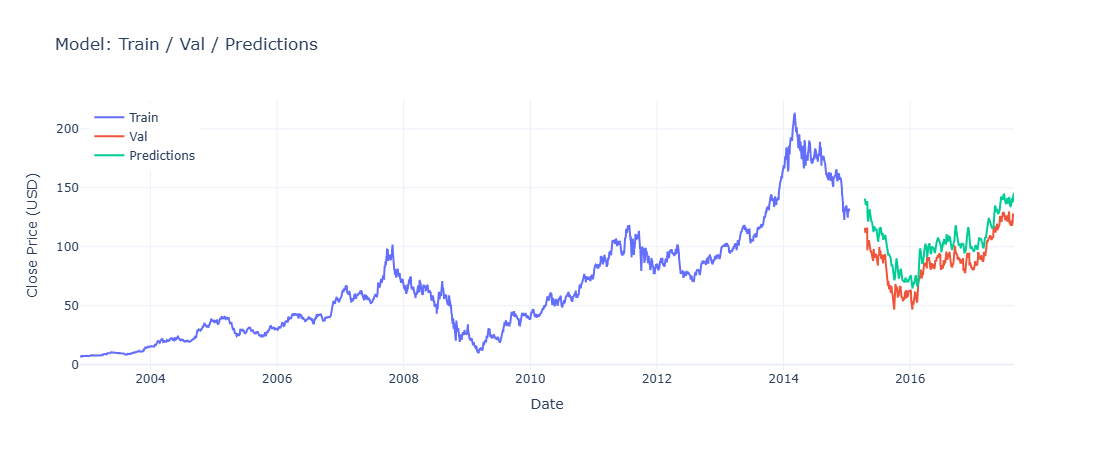

In [20]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go


y_val_pred_scaled = model1.predict(X_val).reshape(-1,1)

dummy = np.zeros((len(y_val_pred_scaled), train_df.shape[1]))
dummy[:, 0] = y_val_pred_scaled[:, 0]
# invert scale
val_pred_close = scaler.inverse_transform(dummy)[:, 0]

# 2. Align with your original dates
#    We dropped the first `window` rows when creating X_val, so:
val_dates = df['Date'].iloc[n_train + window : n_val].reset_index(drop=True)

# Build a val‐DataFrame with true vs. predicted closes
val_plot = pd.DataFrame({
    'Date': val_dates,
    'Close':    test_df.index.empty and val_df['Close'].iloc[window:].values 
               or val_df['Adj Close'].iloc[window:].values,  # use the appropriate column name
    'Prediction': val_pred_close
})

# 3. Plot in Plotly
fig = go.Figure()

# training series
train_plot = pd.DataFrame({
    'Date': df['Date'].iloc[:n_train].reset_index(drop=True),
    'Close': train_df['Adj Close'].values
})
fig.add_trace(go.Scatter(
    x=train_plot['Date'], y=train_plot['Close'],
    mode='lines', name='Train'
))

# validation (true)
fig.add_trace(go.Scatter(
    x=val_plot['Date'], y=val_plot['Close'],
    mode='lines', name='Val'
))

# validation (predictions)
fig.add_trace(go.Scatter(
    x=val_plot['Date'], y=val_plot['Prediction'],
    mode='lines', name='Predictions'
))

fig.update_layout(
    title='Model: Train / Val / Predictions',
    xaxis_title='Date',
    yaxis_title='Close Price (USD)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=900, height=450
)

fig.show()


In [22]:
y_pred = model1.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


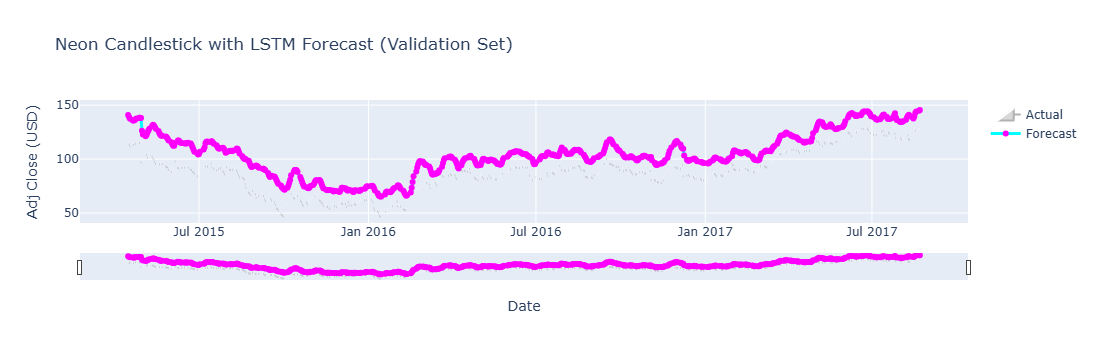

In [30]:
# 1. Invert‐scale your predictions back to USD
y_val_pred = model1.predict(X_val)          # shape = (n_val - window, 1)

# 2. Invert‐scale back to USD
y_val_scaled = y_val_pred.reshape(-1, 1)
dummy = np.zeros((len(y_val_scaled), train_df.shape[1]))
dummy[:, 0] = y_val_scaled[:, 0]             # target_col index = 0 = Adj Close
pred_val_close = scaler.inverse_transform(dummy)[:, 0]

# 3. Align true validation closes and dates (drop first `window` rows)
val_actual = val_df['Adj Close'].iloc[window:].reset_index(drop=True)
val_dates  = df['Date'].iloc[n_train + window : n_val].reset_index(drop=True)

# 4. Build plot DataFrame
plot_df = pd.DataFrame({
    'Date':     val_dates,
    'Actual':   val_actual,
    'Forecast': pred_val_close
})

# 5. Plot with Plotly
fig = go.Figure()

# Candlesticks (using Actual as both open/high/low/close for simplicity)
fig.add_trace(go.Candlestick(
    x=plot_df['Date'],
    open=plot_df['Actual'],
    high=plot_df['Actual'],
    low=plot_df['Actual'],
    close=plot_df['Actual'],
    name='Actual',
    increasing_line_color='white',
    decreasing_line_color='gray',
    opacity=0.6
))

# Forecast line
fig.add_trace(go.Scatter(
    x=plot_df['Date'],
    y=plot_df['Forecast'],
    mode='lines+markers',
    name='Forecast',
    line=dict(color='cyan', width=3),
    marker=dict(color='magenta', size=6)
))

fig.update_layout(
    title='Neon Candlestick with LSTM Forecast (Validation Set)',
    xaxis_title='Date',
    yaxis_title='Adj Close (USD)',
)

fig.show()
